# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: Daniele Pristerà

**Matricola**: 1657095

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

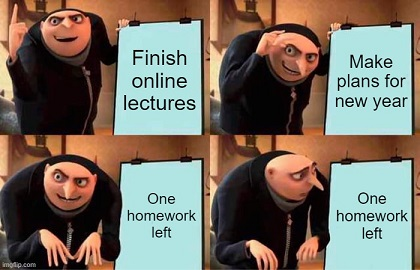

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, initializers, regularizers
from tensorflow.keras import losses, metrics, optimizers, callbacks
import numpy as np
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

The dataset is avalaible on the TensorFlow catalog , it is composed of images of variable dimensions (all resized at 160X200 resolution) subdivided in two categories. The categories are ["Parasitezed" ,"Uninfected"] and represent if a cell is infected with malaria or not. The goal is to create a NeuralNetwork able to correctly evaluates and discriminate the presence of the infecting disease.

In [4]:
train_data, val_data, test_data= tfds.load('malaria', as_supervised=True, split = ["train[:15000]", "train[15000:24000]", "train[24000:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete9C63Y1/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(train_data.cardinality())
print(val_data.cardinality())
print(test_data.cardinality())

tf.Tensor(15000, shape=(), dtype=int64)
tf.Tensor(9000, shape=(), dtype=int64)
tf.Tensor(3558, shape=(), dtype=int64)


In [6]:
def preprocess(image, label):
    # A function that preprocesses each image by normalizing
    # its values in [0, 1].
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def resize_image(image, label):
    image = tf.image.resize_with_pad(image, target_height=160,
    target_width=200, antialias=True)
    return image, label

train_data_p = train_data.map(resize_image).map(preprocess).batch(100)
val_data_p = val_data.map(resize_image).map(preprocess).batch(100)
test_data_p= test_data.map(resize_image).map(preprocess).batch(100)

In [19]:
from tqdm import tqdm
true_label_train=[]
for xb, yb in tqdm(train_data_p.unbatch()):
  true_label_train.append(int(yb))

15000it [00:41, 364.68it/s]


In [7]:
from tqdm import tqdm
true_label_val=[]
for xb, yb in tqdm(val_data_p.unbatch()):
  true_label_val.append(int(yb))

9000it [00:14, 615.56it/s]


In [20]:
from tqdm import tqdm
true_label_test=[]
for xb, yb in tqdm(test_data_p.unbatch()):
  true_label_test.append(int(yb))

3558it [00:10, 344.08it/s]


The whole dataset is balanced respect to the six classes, but since i'm using a subportion of it, in order to ensure to have a good enough variability of the labels, i have plotted the histograms of the various data subsets.

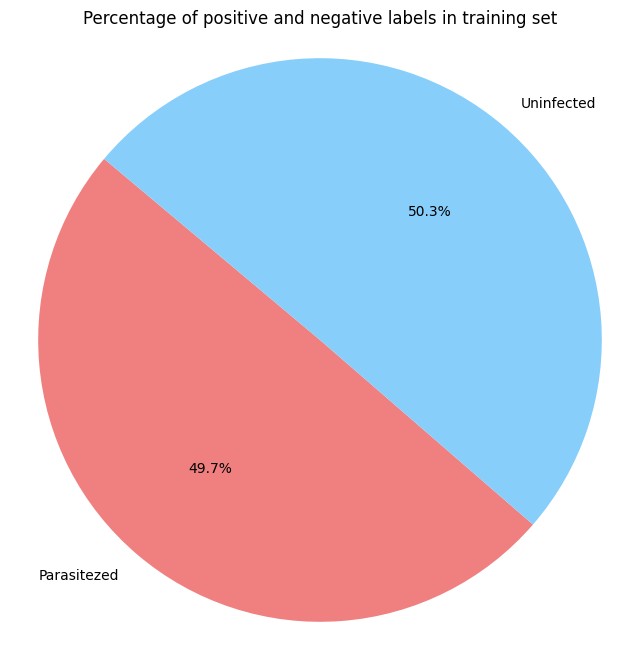

In [9]:
labels = ['Parasitezed', "Uninfected"]
count_0 = 1-np.sum(true_label_train)/len(true_label_train)
count_1 = np.sum(true_label_train)/len(true_label_train)
sizes = [count_0, count_1]
colors = ['lightcoral', 'lightskyblue']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of positive and negative labels in training set')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

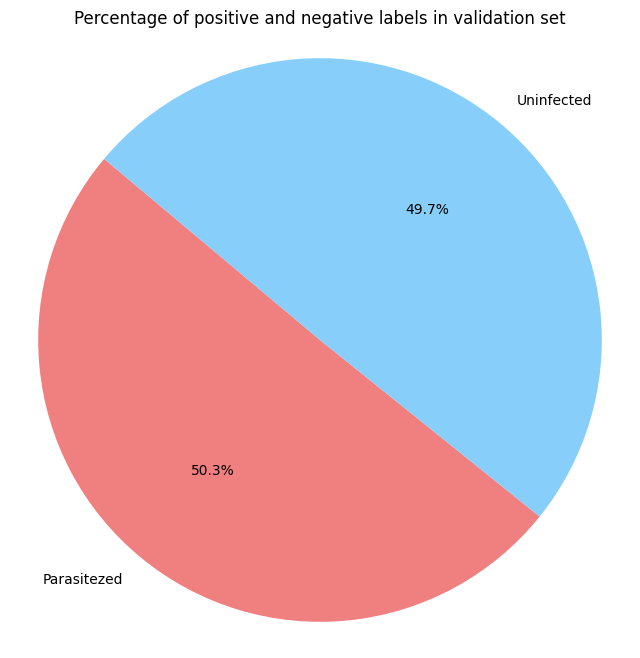

In [10]:
labels = ['Parasitezed', "Uninfected"]
count_0 = 1-np.sum(true_label_val)/len(true_label_val)
count_1 = np.sum(true_label_val)/len(true_label_val)
sizes = [count_0, count_1]
colors = ['lightcoral', 'lightskyblue']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of positive and negative labels in validation set')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

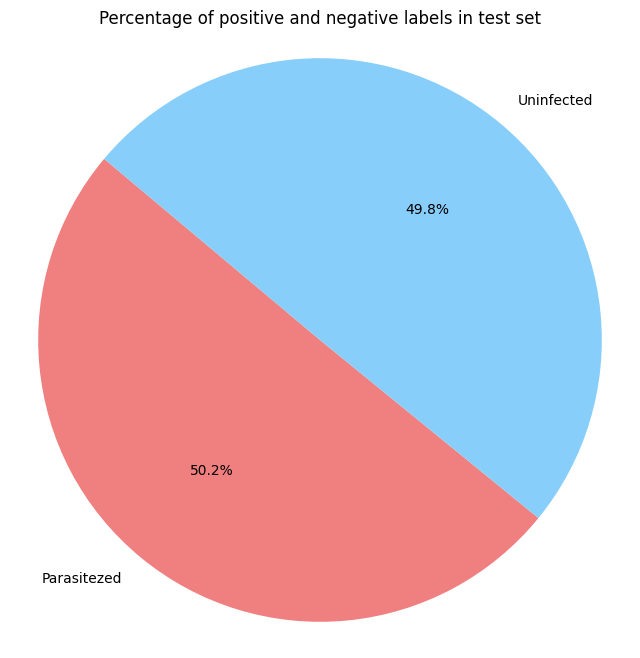

In [11]:
labels = ['Parasitezed', "Uninfected"]
count_0 = 1-np.sum(true_label_test)/len(true_label_test)
count_1 = np.sum(true_label_test)/len(true_label_test)
sizes = [count_0, count_1]
colors = ['lightcoral', 'lightskyblue']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of positive and negative labels in test set')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

The Model is composed by a primary block (Router) whose purposes is to calculate for every image a weight to assign to each block expert.

Then, each image is passed to 4 parallel and equal blocks (the BlockExperts) every expert has a combination of DepthWise and fully connected layers

The results are then combined with a weighted average sum, using the weights calculated by the Router

In [7]:
class DepthConv2D_Block(tf.keras.layers.Layer):
  # simple convolutional block with layer normalization and max pooling
  def __init__(self,  kernel_size, depth_multiplier, pool_size, regularization):
    super().__init__()
    self.DepConv = tf.keras.layers.DepthwiseConv2D(kernel_size, depth_multiplier, padding='same',kernel_regularizer=tf.keras.regularizers.L2(regularization))
    self.norm = tf.keras.layers.BatchNormalization()
    self.pool = tf.keras.layers.AveragePooling2D(pool_size)

  def call(self, inputs):
    x = self.DepConv(inputs)
    x = self.norm(x)
    x = tf.nn.relu(x)
    return self.pool(x)

class Router(tf.keras.layers.Layer):
    def __init__(self, n_xprt, downsampling):
        super().__init__()
        self.Depconv = DepthConv2D_Block(kernel_size=32, depth_multiplier=1, pool_size=1, regularization=(10e-2))
        self.pool_A = tf.keras.layers.AveragePooling2D(downsampling)
        self.pool_G = tf.keras.layers.GlobalAveragePooling2D()
        self.hidden = tf.keras.layers.Dense(128, activation="relu")
        self.softmax = tf.keras.layers.Dense(n_xprt, activation="softmax")

    def call(self, inputs):
        x = self.Depconv(inputs)
        x = self.pool_A(x)
        processed_images = x
        x = self.pool_G(x)
        x = self.hidden(x)
        x = self.softmax(x)

        return x, processed_images


class BlockExpert0(tf.keras.layers.Layer):
  def __init__(self, num_classes):
    super().__init__()
    self.layer_1 = DepthConv2D_Block(kernel_size=32, depth_multiplier=4,pool_size=2, regularization=(10e-2))
    self.layer_2 =  DepthConv2D_Block(kernel_size=32, depth_multiplier=3,pool_size=1, regularization=(10e-2))
    self.layer_3 =  DepthConv2D_Block(kernel_size=16, depth_multiplier=2,pool_size=1, regularization=(10e-2))
    self.pool_G = tf.keras.layers.GlobalAveragePooling2D()
    self.norm1 = tf.keras.layers.BatchNormalization()
    self.norm2 = tf.keras.layers.BatchNormalization()
    self.norm3 = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.dp1 = tf.keras.layers.Dropout(0.4)
    self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    self.dp2 = tf.keras.layers.Dropout(0.2)
    self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.norm1(x)
    x = self.layer_2(x)
    x = self.norm2(x)
    x = self.layer_3(x)
    x = self.pool_G(x)
    x = self.norm3(x)
    x = self.dense1(x)
    x = self.dp1(x)
    x = self.dense2(x)
    x = self.dp2(x)
    x = self.classifier(x)

    return x

class BlockExpert1(tf.keras.layers.Layer):
  def __init__(self, num_classes):
    super().__init__()
    self.layer_1 = DepthConv2D_Block(kernel_size=32, depth_multiplier=4,pool_size=2, regularization=(10e-2))
    self.layer_2 =  DepthConv2D_Block(kernel_size=32, depth_multiplier=3,pool_size=1, regularization=(10e-2))
    self.layer_3 =  DepthConv2D_Block(kernel_size=16, depth_multiplier=2,pool_size=1, regularization=(10e-2))
    self.pool_G = tf.keras.layers.GlobalAveragePooling2D()
    self.norm1 = tf.keras.layers.BatchNormalization()
    self.norm2 = tf.keras.layers.BatchNormalization()
    self.norm3 = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.dp1 = tf.keras.layers.Dropout(0.4)
    self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    self.dp2 = tf.keras.layers.Dropout(0.2)
    self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.norm1(x)
    x = self.layer_2(x)
    x = self.norm2(x)
    x = self.layer_3(x)
    x = self.pool_G(x)
    x = self.norm3(x)
    x = self.dense1(x)
    x = self.dp1(x)
    x = self.dense2(x)
    x = self.dp2(x)
    x = self.classifier(x)

    return x

class BlockExpert2(tf.keras.layers.Layer):
  def __init__(self, num_classes):
    super().__init__()
    self.layer_1 = DepthConv2D_Block(kernel_size=32, depth_multiplier=4,pool_size=2, regularization=(10e-2))
    self.layer_2 =  DepthConv2D_Block(kernel_size=32, depth_multiplier=3,pool_size=1, regularization=(10e-2))
    self.layer_3 =  DepthConv2D_Block(kernel_size=16, depth_multiplier=2,pool_size=1, regularization=(10e-2))
    self.pool_G = tf.keras.layers.GlobalAveragePooling2D()
    self.norm1 = tf.keras.layers.BatchNormalization()
    self.norm2 = tf.keras.layers.BatchNormalization()
    self.norm3 = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.dp1 = tf.keras.layers.Dropout(0.4)
    self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    self.dp2 = tf.keras.layers.Dropout(0.2)
    self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.norm1(x)
    x = self.layer_2(x)
    x = self.norm2(x)
    x = self.layer_3(x)
    x = self.pool_G(x)
    x = self.norm3(x)
    x = self.dense1(x)
    x = self.dp1(x)
    x = self.dense2(x)
    x = self.dp2(x)
    x = self.classifier(x)

    return x

class BlockExpert3(tf.keras.layers.Layer):
  def __init__(self, num_classes):
    super().__init__()
    self.layer_1 = DepthConv2D_Block(kernel_size=32, depth_multiplier=4,pool_size=2, regularization=(10e-2))
    self.layer_2 =  DepthConv2D_Block(kernel_size=32, depth_multiplier=3,pool_size=1, regularization=(10e-2))
    self.layer_3 =  DepthConv2D_Block(kernel_size=16, depth_multiplier=2,pool_size=1, regularization=(10e-2))
    self.pool_G = tf.keras.layers.GlobalAveragePooling2D()
    self.norm1 = tf.keras.layers.BatchNormalization()
    self.norm2 = tf.keras.layers.BatchNormalization()
    self.norm3 = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.dp1 = tf.keras.layers.Dropout(0.4)
    self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    self.dp2 = tf.keras.layers.Dropout(0.2)
    self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.norm1(x)
    x = self.layer_2(x)
    x = self.norm2(x)
    x = self.layer_3(x)
    x = self.pool_G(x)
    x = self.norm3(x)
    x = self.dense1(x)
    x = self.dp1(x)
    x = self.dense2(x)
    x = self.dp2(x)
    x = self.classifier(x)

    return x

class ExpertCNN(tf.keras.Model):
    def __init__(self,num_classes, n_xprt, downsampling_factor):
        super().__init__()
        self.num_classes=num_classes
        self.router = Router(n_xprt, downsampling_factor)
        self.xprts = [BlockExpert0(self.num_classes), BlockExpert1(self.num_classes), BlockExpert2(self.num_classes), BlockExpert3(self.num_classes)]
        self.n_xprt=n_xprt

    def splitting_weights(self, weights, n_xprt): #function that split the weight tensor of dimension (n_xprtXbatch) to each expert
        Expertweights_list=[]
        for i in range(n_xprt):
            Expertweights=weights[:, i]
            Expertweights = tf.expand_dims(Expertweights, axis=1)
            Expertweights_list.append(Expertweights)
        return Expertweights_list

    def call(self, inputs):
        weights, processed_images = self.router(inputs)
        Expertweights_list=self.splitting_weights(weights, self.n_xprt)
        x=0
        for i in range(self.n_xprt):
          x+= self.xprts[i](processed_images) * Expertweights_list[i] #weighted sum of all the experts output

        return tf.nn.softmax(x)


In [13]:
for xb, yb in train_data_p:
  break

In [14]:
model = ExpertCNN(num_classes=2,n_xprt=4, downsampling_factor=2)
model(xb).shape

TensorShape([100, 2])

In [15]:
model.summary()

Model: "expert_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 router (Router)             multiple                  4115      
                                                                 
 block_expert0 (BlockExpert0  multiple                 9395      
 )                                                               
                                                                 
 block_expert1 (BlockExpert1  multiple                 9395      
 )                                                               
                                                                 
 block_expert2 (BlockExpert2  multiple                 9395      
 )                                                               
                                                                 
 block_expert3 (BlockExpert3  multiple                 9395      
 )                                                      

In [16]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
model.compile(loss=cross_entropy, optimizer=optimizer, metrics=[accuracy])
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True, verbose=1),
    callbacks.TensorBoard(log_dir='logs', update_freq=50)
]
model_trained = model.fit(train_data_p, validation_data=val_data_p,epochs=50, callbacks=cbs)

Epoch 1/50
150/150 [==============================] - 64s 375ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.6521 - val_loss: 0.6492 - val_sparse_categorical_accuracy: 0.6263
Epoch 2/50
150/150 [==============================] - 49s 326ms/step - loss: 0.6134 - sparse_categorical_accuracy: 0.6800 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6261
Epoch 3/50
150/150 [==============================] - 51s 338ms/step - loss: 0.6019 - sparse_categorical_accuracy: 0.6897 - val_loss: 0.6367 - val_sparse_categorical_accuracy: 0.6529
Epoch 4/50
150/150 [==============================] - 52s 345ms/step - loss: 0.5930 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.6070 - val_sparse_categorical_accuracy: 0.6821
Epoch 5/50
150/150 [==============================] - 59s 391ms/step - loss: 0.5830 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.5902 - val_sparse_categorical_accuracy: 0.6979
Epoch 6/50
150/150 [==============================] - 52s 346ms/step - loss: 0.5681 -

In [17]:
model.save('/content/drive/MyDrive/my_model', save_format='keras')




✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

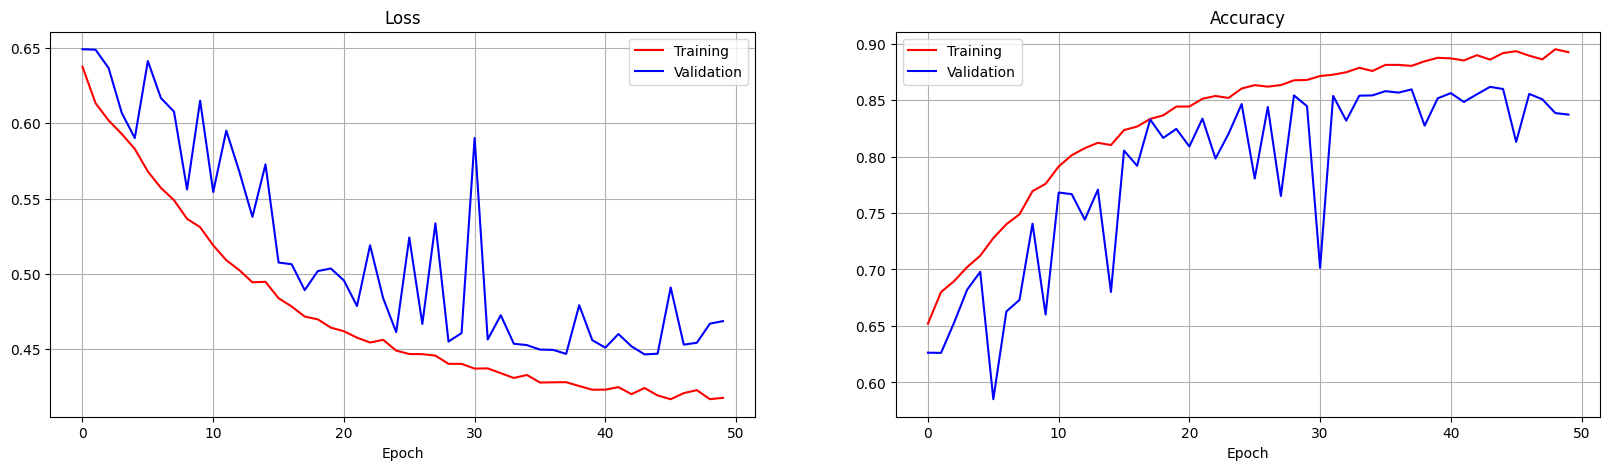

In [18]:
# TODO: add metrics and/or graphs showing the model was trained correctly.
import numpy as np
fig,ax = plt.subplots(1,2, figsize = (20,5))

epochs = np.arange(len(model_trained.history['loss']))
ax[0].plot(epochs, model_trained.history['loss'], label = 'Training', color = 'red')
ax[0].plot(epochs, model_trained.history['val_loss'], label = 'Validation', color = 'blue')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs, model_trained.history['sparse_categorical_accuracy'], label = 'Training', color = 'red')
ax[1].plot(epochs, model_trained.history['val_sparse_categorical_accuracy'], label = 'Validation', color = 'blue')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

36/36 [==============================] - 5s 143ms/step


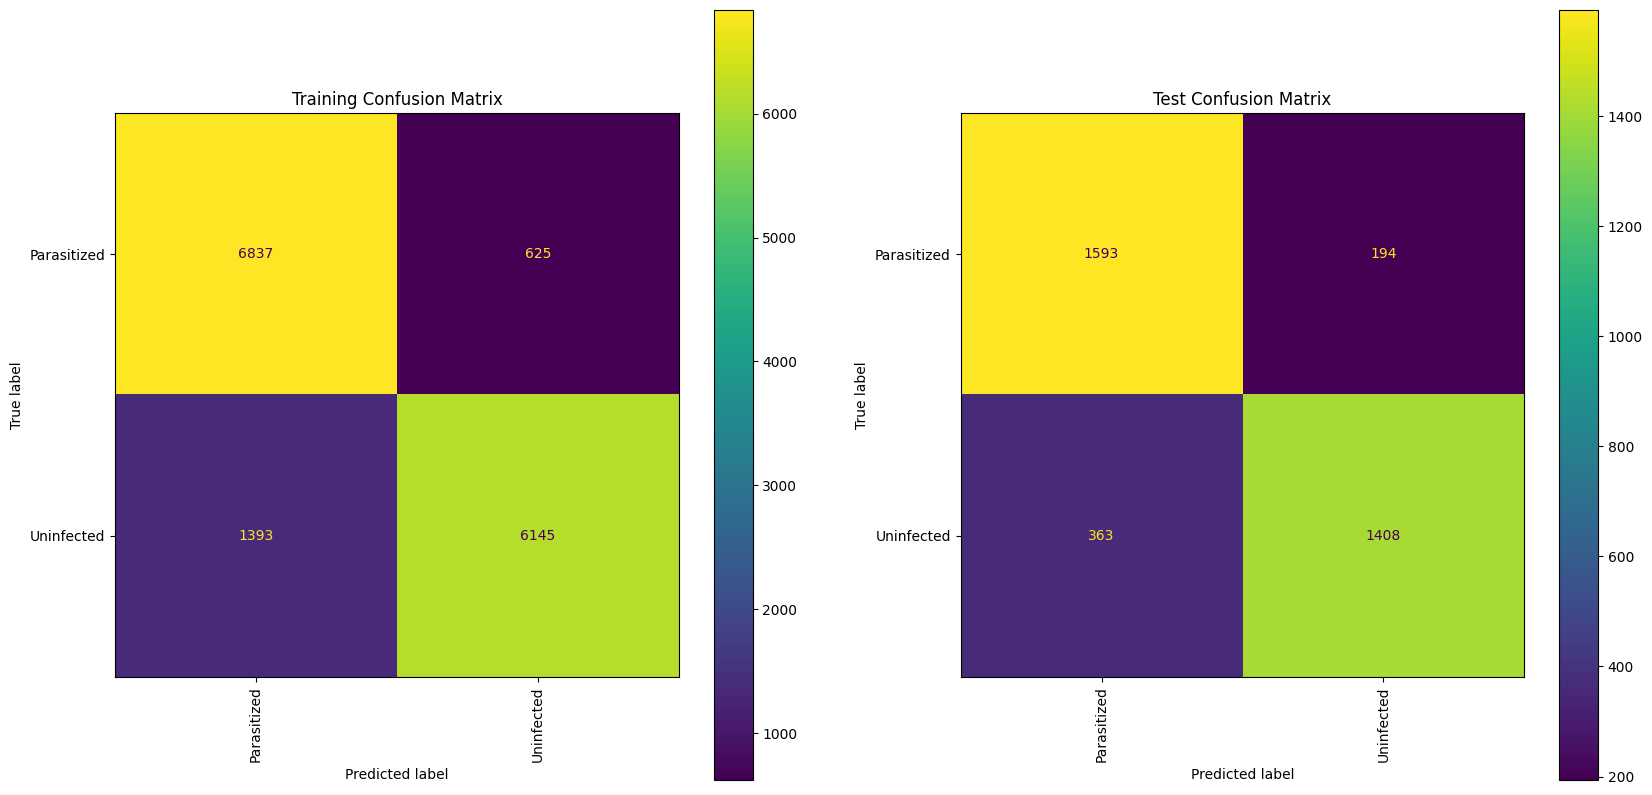

In [19]:
from sklearn import metrics
labels=["Parasitized", "Uninfected"]
fig,ax = plt.subplots(1,2, figsize = (20,10))

results_train = tf.argmax(model.predict(train_data_p), -1)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_label_train, results_train, ax = ax[0])
ax[0].set_xticklabels(labels, rotation = 90)
ax[0].set_yticklabels(labels, rotation = 0)
ax[0].set_title('Training Confusion Matrix')

results_test = tf.argmax(model.predict(test_data_p), -1)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_label_test, results_test, ax = ax[1])
ax[1].set_xticklabels(labels, rotation = 90)
ax[1].set_yticklabels(labels, rotation = 0)
ax[1].set_title('Test Confusion Matrix')

plt.show()

### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

The model has been modified to implement a Mixture of Experts (MoE) approach. Instead of returning a reduced tensor of weights for every image, the new Router split function now selects only the two weights with the highest values. The goal is to use only the two best experts for a given image.

During training, this approach presents a problem: different experts may not see the same number of images, leading to issues with the batch dimension. To address this problem, the 'Split_batch_and_count' function processes each batch of images, separating each image for assignment to each expert. It then populates a zero tensor with the batch dimension, ensuring that each expert receives a batch of the same fixed dimension. The non-zero values in the tensor correspond to the assigned images for each expert. The function also count how many images are assigned to a given expert.

In inference time, assuming a batch size of 1, this approach is not necessary. Instead, only the indices of the two best experts and their weights are passed.

In [8]:
class RouterSplit(tf.keras.layers.Layer):
    def __init__(self, n_xprt, k, downsampling):
        super().__init__()
        self.k=k
        self.Depconv = DepthConv2D_Block(kernel_size=32, depth_multiplier=1, pool_size=1, regularization=(10e-2))
        self.pool_A = tf.keras.layers.AveragePooling2D(downsampling)
        self.pool_G = tf.keras.layers.GlobalAveragePooling2D()
        self.hidden = tf.keras.layers.Dense(128, activation="relu")
        self.softmax = tf.keras.layers.Dense(n_xprt, activation="softmax")

    def call(self, inputs):
        x = self.Depconv(inputs)
        x = self.pool_A(x)
        processed_images = x
        x = self.pool_G(x)
        x = self.hidden(x)
        x = self.softmax(x)
        top_k = tf.math.top_k(x, k=self.k)
        return top_k, processed_images



class Split_batch_and_count(tf.keras.layers.Layer):
    def __init__(self, n_xprt):
        super().__init__()
        self.n_xprt = n_xprt


    def weight_batching(self, num_xprts, weights, indices):
      first_indices = indices[:, 0]
      second_indices = indices[:, 1]
      zerotensor = tf.zeros_like(weights[:,0])
      weight_list_first_index=[]
      weight_list_second_index=[]
      for i in range(num_xprts):
        index_to_assign=tf.where(first_indices==i)
        mask=tf.equal(first_indices, i)
        weights_tensor=tf.boolean_mask(weights[:,0], mask)
        weight_list_first_index.append(tf.tensor_scatter_nd_update(zerotensor, index_to_assign, weights_tensor))
      for i in range(num_xprts):
        index_to_assign=tf.where(second_indices==i)
        mask=tf.equal(second_indices, i)
        weights_tensor=tf.boolean_mask(weights[:,1], mask)
        weight_list_second_index.append(tf.tensor_scatter_nd_update(zerotensor, index_to_assign, weights_tensor))
      weights_list=[tf.add(weight_list_first_index[i],weight_list_second_index[i]) for i in range(num_xprts)]
      return weights_list

    def batching_and_count(self, num_xprts, images, indices):
      first_indices = indices[:, 0]
      second_indices = indices[:, 1]
      zerotensor = tf.zeros_like(images)
      batch_count=[]
      batch_list=[]
      for i in range(num_xprts):
        index_to_assign=tf.where(((first_indices==i) | (second_indices==i)))
        mask=tf.equal(first_indices, i) | tf.equal(second_indices, i)
        batch_tensor=tf.boolean_mask(images, mask)
        batch_count.append(tf.shape(batch_tensor)[0])
        batch_list.append(tf.tensor_scatter_nd_update(zerotensor, index_to_assign, batch_tensor))
      return batch_list , batch_count

    def call(self, image, weights_tensor, indices_tensor):

        # Scheduler:
        weights_tensor = weights_tensor / tf.reduce_sum(weights_tensor, axis=1, keepdims=True)
        batch_list, batch_sizes = self.batching_and_count(self.n_xprt, image, indices_tensor)
        weight_batch = self.weight_batching(self.n_xprt, weights_tensor, indices_tensor)

        return batch_list , weight_batch, batch_sizes


class Top_K_Expert_Model(tf.keras.Model):
    def __init__(self, num_classes, n_xprt, downsampling_factor, train):
        super().__init__()
        self.num_classes=num_classes
        self.n_xprt = n_xprt
        self.router = RouterSplit(self.n_xprt, k=2, downsampling=2)
        self.split = Split_batch_and_count(self.n_xprt)
        self.xprts = [BlockExpert0(num_classes=self.num_classes), BlockExpert1(num_classes=self.num_classes),
                      BlockExpert2(num_classes=self.num_classes), BlockExpert3(num_classes=self.num_classes)]
        self.counter = self.add_weight(name='counter', shape=(self.n_xprt,), initializer='zeros', trainable=False)
        self.train=train
    def splitting_weights_top_k(self, weights, n_xprt):
        Expertweights_list=[]
        for i in range(n_xprt):
            Expertweights=weights[i]
            Expertweights = tf.expand_dims(Expertweights, axis=1)
            Expertweights_list.append(Expertweights)
        return Expertweights_list




    def call(self, inputs):
      topk, processed_images = self.router(inputs)
      if self.train == True:
        batches, weights, count= self.split(processed_images, topk.values, topk.indices)
        self.counter.assign_add(tf.cast(count, self.counter.dtype))
        Expertweights_list=self.splitting_weights_top_k(weights, self.n_xprt)
        x=0
        for i in range(self.n_xprt):
          x+= self.xprts[i](batches[i]) * Expertweights_list[i]

        return tf.nn.softmax(x)

      else:
        weights = np.array(topk.values)[0]/np.sum(np.array(topk.values)[0], axis=0)
        x1=self.xprts[np.array(topk.indices)[0][0]](processed_images) * weights[0]
        x2=self.xprts[np.array(topk.indices)[0][1]](processed_images) * weights[1]
        x = tf.nn.softmax(x1 + x2)
        return (x)



In [21]:
model_Expert=Top_K_Expert_Model(num_classes=2,n_xprt=4, downsampling_factor=2, train=True)
model_Expert.load_weights('/content/drive/MyDrive/my_model')

In [22]:
for xb, yb in train_data_p:
  break

In [23]:
model_Expert(xb).shape

TensorShape([100, 2])

In [24]:
model_Expert.summary()

Model: "top_k__expert__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 router_split (RouterSplit)  multiple                  4115      
                                                                 
 split_batch_and_count (Spli  multiple                 0         
 t_batch_and_count)                                              
                                                                 
 block_expert0_1 (BlockExper  multiple                 9395      
 t0)                                                             
                                                                 
 block_expert1_1 (BlockExper  multiple                 9395      
 t1)                                                             
                                                                 
 block_expert2_1 (BlockExper  multiple                 9395      
 t2)                                          

In [25]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
initial_learning_rate = 0.0001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
model_Expert.compile(loss=cross_entropy, optimizer=optimizer, metrics=[accuracy])
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10

                            ,
                            restore_best_weights=True, verbose=1),
    callbacks.TensorBoard(log_dir='logs', update_freq=50)
]
model_trained_2= model_Expert.fit(train_data_p, validation_data=val_data_p,epochs=50, callbacks=cbs)

Epoch 1/50
150/150 [==============================] - 71s 419ms/step - loss: 0.4290 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.4525 - val_sparse_categorical_accuracy: 0.8572
Epoch 2/50
150/150 [==============================] - 54s 360ms/step - loss: 0.4174 - sparse_categorical_accuracy: 0.8937 - val_loss: 0.4488 - val_sparse_categorical_accuracy: 0.8621
Epoch 3/50
150/150 [==============================] - 54s 360ms/step - loss: 0.4146 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.4485 - val_sparse_categorical_accuracy: 0.8608
Epoch 4/50
150/150 [==============================] - 61s 405ms/step - loss: 0.4122 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.4475 - val_sparse_categorical_accuracy: 0.8631
Epoch 5/50
150/150 [==============================] - 61s 405ms/step - loss: 0.4109 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.4492 - val_sparse_categorical_accuracy: 0.8599
Epoch 6/50
150/150 [==============================] - 54s 361ms/step - loss: 0.4094 -

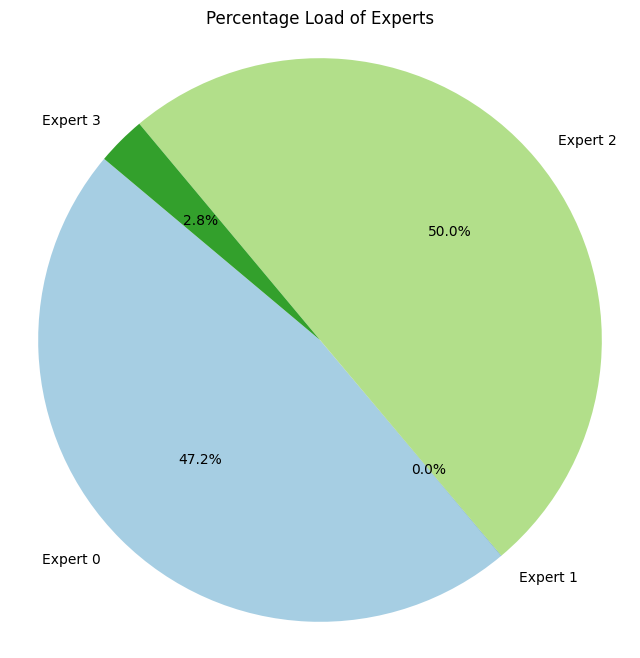

In [26]:
percentage_loads = tf.linalg.normalize(model_Expert.counter, ord=1)[0]
experts = ['Expert 0', 'Expert 1', 'Expert 2', 'Expert 3']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentage_loads, labels=experts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage Load of Experts')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

In [27]:
model_Expert.save('/content/drive/MyDrive/my_model_2', save_format='keras')

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

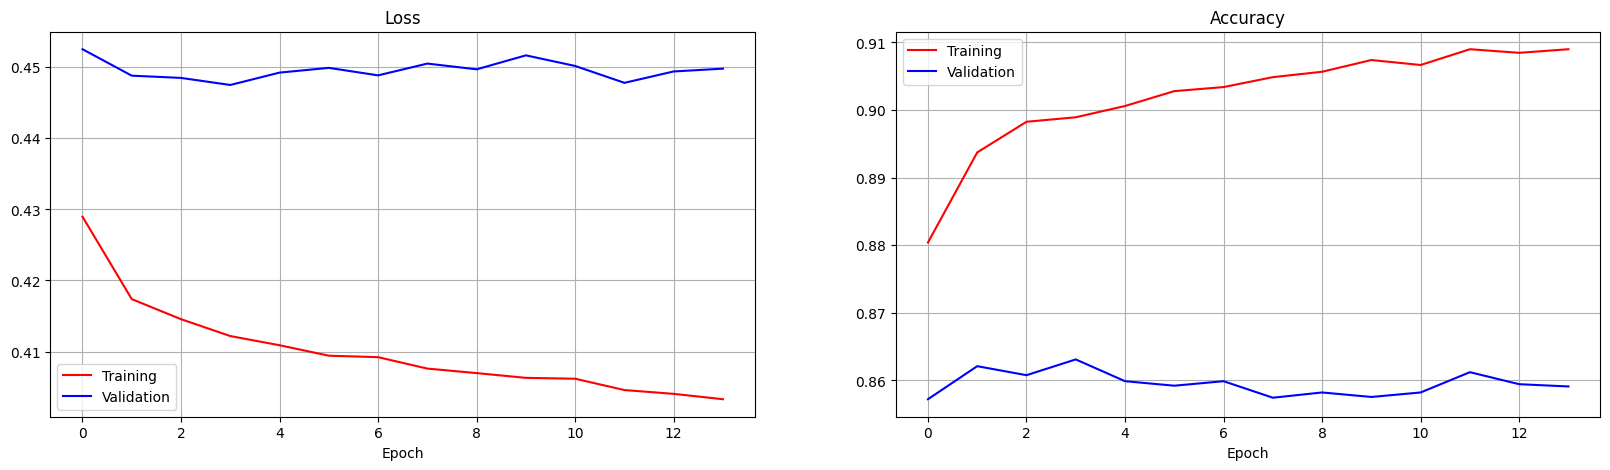

In [28]:
fig,ax = plt.subplots(1,2, figsize = (20,5))

epochs = np.arange(len(model_trained_2.history['loss']))
ax[0].plot(epochs, model_trained_2.history['loss'], label = 'Training', color = 'red')
ax[0].plot(epochs, model_trained_2.history['val_loss'], label = 'Validation', color = 'blue')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(epochs, model_trained_2.history['sparse_categorical_accuracy'], label = 'Training', color = 'red')
ax[1].plot(epochs, model_trained_2.history['val_sparse_categorical_accuracy'], label = 'Validation', color = 'blue')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

In [9]:
model_Expert_Inference=Top_K_Expert_Model(num_classes=2,n_xprt=4, downsampling_factor=2, train=False)
model_Expert_Inference.load_weights('/content/drive/MyDrive/my_model_2')

In [30]:
train_data_inference = train_data.shuffle(1000).batch(1).map(preprocess)
test_data_inference= test_data.batch(1).map(preprocess)

In [31]:
result_inference_train=[]
for example, y in tqdm(train_data_inference):
  result_inference_train.append(int(tf.argmax(model_Expert_Inference(example), -1)))

100%|██████████| 15000/15000 [08:21<00:00, 29.94it/s]


In [32]:
result_inference_test=[]
for example, y in tqdm(test_data_inference):
  result_inference_test.append(int(tf.argmax(model_Expert_Inference(example), -1)))

100%|██████████| 3558/3558 [02:21<00:00, 25.06it/s]


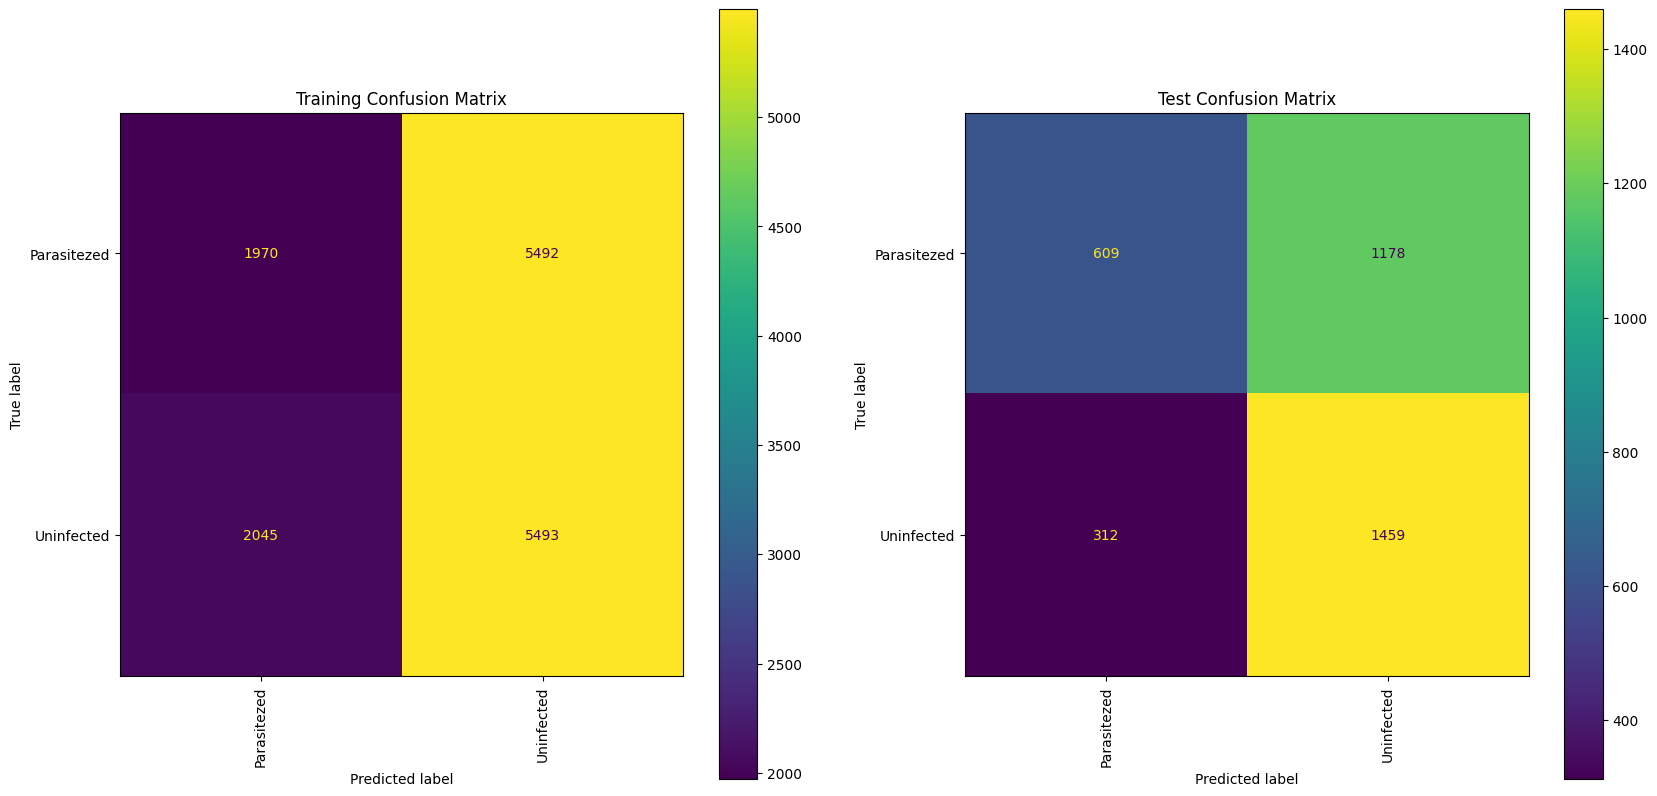

In [33]:
from sklearn import metrics
labels=["Parasitezed", "Uninfected"]
fig,ax = plt.subplots(1,2, figsize = (20,10))


cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_label_train, result_inference_train, ax = ax[0])
ax[0].set_xticklabels(labels, rotation = 90)
ax[0].set_yticklabels(labels, rotation = 0)
ax[0].set_title('Training Confusion Matrix')


cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_label_test, result_inference_test, ax = ax[1])
ax[1].set_xticklabels(labels, rotation = 90)
ax[1].set_yticklabels(labels, rotation = 0)
ax[1].set_title('Test Confusion Matrix')

plt.show()

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

In the latest iteration of the model, a load balancing loss has been introduced with the aim of achieving a more even utilization of each expert. This new loss is computed using KL divergence, which compares the distribution of images within each batch to an ideal uniform distribution.

In [10]:
class LoadBalancingLoss(tf.keras.losses.Loss):

    def __init__(self, balancing_distr):
        super().__init__()
        self.balancing_distr = balancing_distr
        self.kl = tf.keras.losses.KLDivergence()

    def call(self, y_true, workrs):
        return self.kl(self.balancing_distr, workrs)



class Top_K_Expert_Model_LB(tf.keras.Model):
    def __init__(self, num_classes, n_xprt, downsampling_factor, train):
        super().__init__()
        self.num_classes=num_classes
        self.n_xprt = n_xprt
        self.router = RouterSplit(self.n_xprt, k=2, downsampling=2)
        self.split = Split_batch_and_count(self.n_xprt)
        self.xprts = [BlockExpert0(num_classes=self.num_classes), BlockExpert1(num_classes=self.num_classes),
                      BlockExpert2(num_classes=self.num_classes), BlockExpert3(num_classes=self.num_classes)]
        self.counter = self.add_weight(name='counter', shape=(self.n_xprt,), initializer='zeros', trainable=False)
        self.train=train
    def splitting_weights_top_k(self, weights, n_xprt):
        Expertweights_list=[]
        for i in range(n_xprt):
            Expertweights=weights[i]
            Expertweights = tf.expand_dims(Expertweights, axis=1)
            Expertweights_list.append(Expertweights)
        return Expertweights_list




    def call(self, inputs):
      topk, processed_images = self.router(inputs)
      if self.train == True:
        batches, weights, count= self.split(processed_images, topk.values, topk.indices)
        self.counter.assign_add(tf.cast(count, self.counter.dtype))
        Expertweights_list=self.splitting_weights_top_k(weights, self.n_xprt)
        x=0
        for i in range(self.n_xprt):
          x+= self.xprts[i](batches[i]) * Expertweights_list[i]
        workers_load = tf.linalg.normalize(count, ord=1)[0]
        workers_load = tf.expand_dims(workers_load, axis=0)
        return [(tf.nn.softmax(x), workers_load)]

      else:
        weights = np.array(topk.values)[0]/np.sum(np.array(topk.values)[0], axis=0)
        x1=self.xprts[np.array(topk.indices)[0][0]](processed_images) * weights[0]
        x2=self.xprts[np.array(topk.indices)[0][1]](processed_images) * weights[1]
        x = tf.nn.softmax(x1 + x2)
        return (x)



In [35]:
loss_weights = np.array([1, 5]) # this will try to skew the model more to the second loss
loss_weights = list(loss_weights/loss_weights.sum())
balancing_distr = tf.ones((1,4))/4 #uniform distribution

In [36]:
for xb, yb in train_data_p:
  break

In [37]:
model_Expert_LB=Top_K_Expert_Model_LB(num_classes=2,n_xprt=4, downsampling_factor=2, train=True)
model_Expert_LB.load_weights('/content/drive/MyDrive/my_model')
model_Expert_LB(xb)

[(<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
  array([[0.5852817 , 0.4147183 ],
         [0.2689969 , 0.73100305],
         [0.73105854, 0.26894143],
         [0.27143177, 0.72856826],
         [0.27461085, 0.7253892 ],
         [0.73105854, 0.26894143],
         [0.26901808, 0.7309819 ],
         [0.2689643 , 0.7310357 ],
         [0.73105854, 0.26894143],
         [0.73105854, 0.26894143],
         [0.28507936, 0.71492064],
         [0.28832752, 0.71167254],
         [0.2689418 , 0.73105824],
         [0.27690688, 0.7230931 ],
         [0.73105854, 0.26894143],
         [0.73105854, 0.26894143],
         [0.26955602, 0.730444  ],
         [0.27668664, 0.7233134 ],
         [0.7304174 , 0.2695827 ],
         [0.26904258, 0.73095745],
         [0.73105854, 0.2689415 ],
         [0.73105854, 0.26894143],
         [0.28598544, 0.71401453],
         [0.73105854, 0.26894143],
         [0.73105854, 0.26894143],
         [0.2700843 , 0.7299157 ],
         [0.26894143, 0.73105854],
   

In [38]:
model_Expert_LB.summary()

Model: "top_k__expert__model_lb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 router_split_2 (RouterSplit  multiple                 4115      
 )                                                               
                                                                 
 split_batch_and_count_2 (Sp  multiple                 0         
 lit_batch_and_count)                                            
                                                                 
 block_expert0_3 (BlockExper  multiple                 9395      
 t0)                                                             
                                                                 
 block_expert1_3 (BlockExper  multiple                 9395      
 t1)                                                             
                                                                 
 block_expert2_3 (BlockExper  multiple     

In [39]:
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
model_Expert_LB.compile(loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), LoadBalancingLoss(balancing_distr)],
    loss_weights = loss_weights, optimizer=optimizer, metrics=[accuracy])
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_output_1_1_sparse_categorical_accuracy', patience=10,
                            restore_best_weights=True, verbose=1),
    callbacks.TensorBoard(log_dir='logs', update_freq=50)
]
model_Expert_LB_trained = model_Expert_LB.fit(train_data_p, validation_data=val_data_p, epochs=50, callbacks=cbs)

Epoch 1/50
150/150 [==============================] - 68s 406ms/step - loss: 3.1857 - output_1_1_loss: 0.4272 - output_1_2_loss: 3.7374 - output_1_1_sparse_categorical_accuracy: 0.8833 - output_1_2_sparse_categorical_accuracy: 0.0000e+00 - val_loss: 3.3042 - val_output_1_1_loss: 0.4502 - val_output_1_2_loss: 3.8749 - val_output_1_1_sparse_categorical_accuracy: 0.8603 - val_output_1_2_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/50
150/150 [==============================] - 60s 402ms/step - loss: 3.6046 - output_1_1_loss: 0.4151 - output_1_2_loss: 4.2426 - output_1_1_sparse_categorical_accuracy: 0.8963 - output_1_2_sparse_categorical_accuracy: 0.0292 - val_loss: 4.4035 - val_output_1_1_loss: 0.4510 - val_output_1_2_loss: 5.1940 - val_output_1_1_sparse_categorical_accuracy: 0.8576 - val_output_1_2_sparse_categorical_accuracy: 0.1752
Epoch 3/50
150/150 [==============================] - 55s 367ms/step - loss: 4.2608 - output_1_1_loss: 0.4124 - output_1_2_loss: 5.0305 - output_1_1_spars

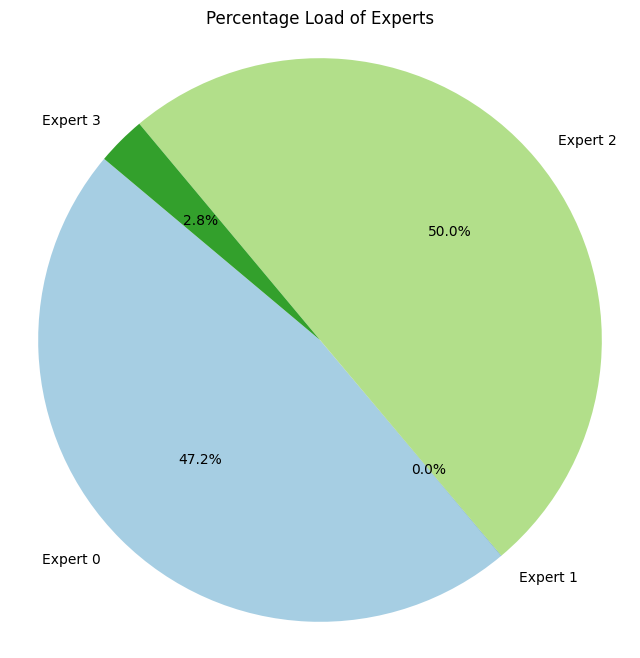

In [40]:
percentage_loads = tf.linalg.normalize(model_Expert.counter, ord=1)[0]
experts = ['Expert 0', 'Expert 1', 'Expert 2', 'Expert 3']
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentage_loads, labels=experts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage Load of Experts')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

In [41]:
model_Expert_LB.save('/content/drive/MyDrive/my_model_3', save_format='keras')

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

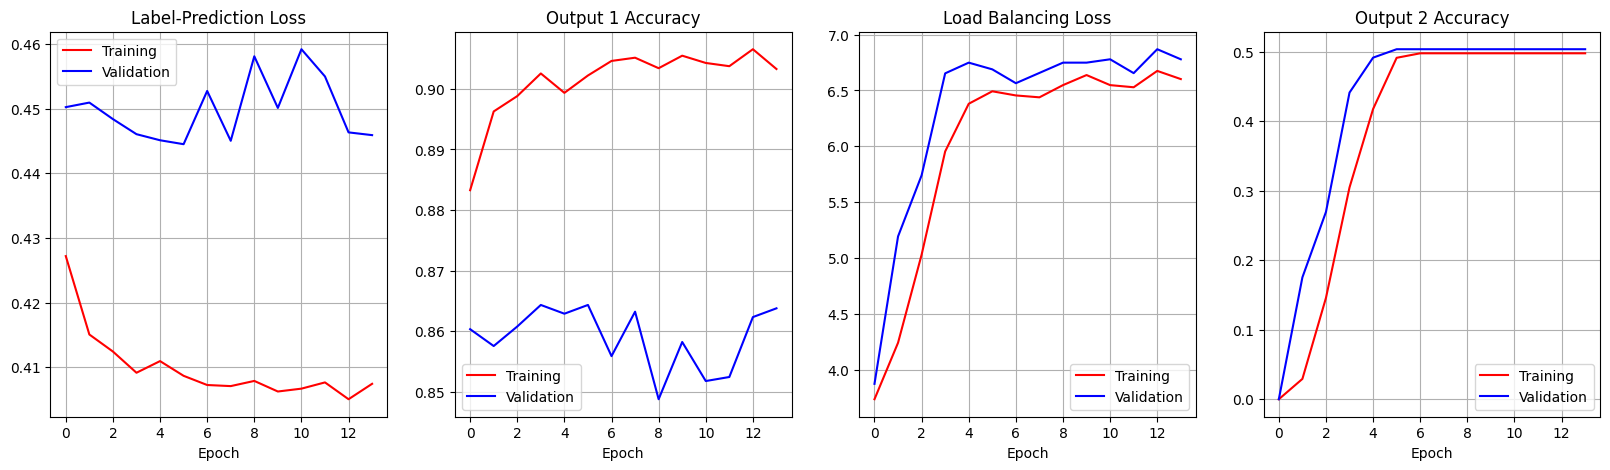

In [42]:
fig,ax = plt.subplots(1,4, figsize = (20,5))

epochs = np.arange(len(model_Expert_LB_trained.history['loss']))
ax[0].plot(epochs, model_Expert_LB_trained.history['output_1_1_loss'], label = 'Training', color = 'red')
ax[0].plot(epochs, model_Expert_LB_trained.history['val_output_1_1_loss'], label = 'Validation', color = 'blue')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Label-Prediction Loss')
ax[0].legend()
ax[0].grid()



ax[1].plot(epochs, model_Expert_LB_trained.history['output_1_1_sparse_categorical_accuracy'], label = 'Training', color = 'red')
ax[1].plot(epochs, model_Expert_LB_trained.history['val_output_1_1_sparse_categorical_accuracy'], label = 'Validation', color = 'blue')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Output 1 Accuracy')
ax[1].legend()
ax[1].grid()

ax[2].plot(epochs, model_Expert_LB_trained.history['output_1_2_loss'], label = 'Training', color = 'red')
ax[2].plot(epochs, model_Expert_LB_trained.history['val_output_1_2_loss'], label = 'Validation', color = 'blue')
ax[2].set_xlabel('Epoch')
ax[2].set_title('Load Balancing Loss')
ax[2].legend()
ax[2].grid()


ax[3].plot(epochs, model_Expert_LB_trained.history['output_1_2_sparse_categorical_accuracy'], label = 'Training', color = 'red')
ax[3].plot(epochs, model_Expert_LB_trained.history['val_output_1_2_sparse_categorical_accuracy'], label = 'Validation', color = 'blue')
ax[3].set_xlabel('Epoch')
ax[3].set_title('Output 2 Accuracy')
ax[3].legend()
ax[3].grid()

plt.show()

In [11]:
model_Expert_LB_Inference=Top_K_Expert_Model_LB(num_classes=2,n_xprt=4, downsampling_factor=2, train=False)
model_Expert_LB_Inference.load_weights('/content/drive/MyDrive/my_model_3')

In [15]:
train_data_inference = train_data.shuffle(1000).batch(1).map(preprocess)
test_data_inference= test_data.batch(1).map(preprocess)

In [16]:
result_inference_LB_train=[]
for example, y in tqdm(train_data_inference):
  result_inference_LB_train.append(int(tf.argmax(model_Expert_LB_Inference(example), -1)))

100%|██████████| 15000/15000 [1:09:24<00:00,  3.60it/s]


In [17]:
result_inference_LB_test=[]
for example, y in tqdm(test_data_inference):
  result_inference_LB_test.append(int(tf.argmax(model_Expert_LB_Inference(example), -1)))

100%|██████████| 3558/3558 [16:21<00:00,  3.62it/s]


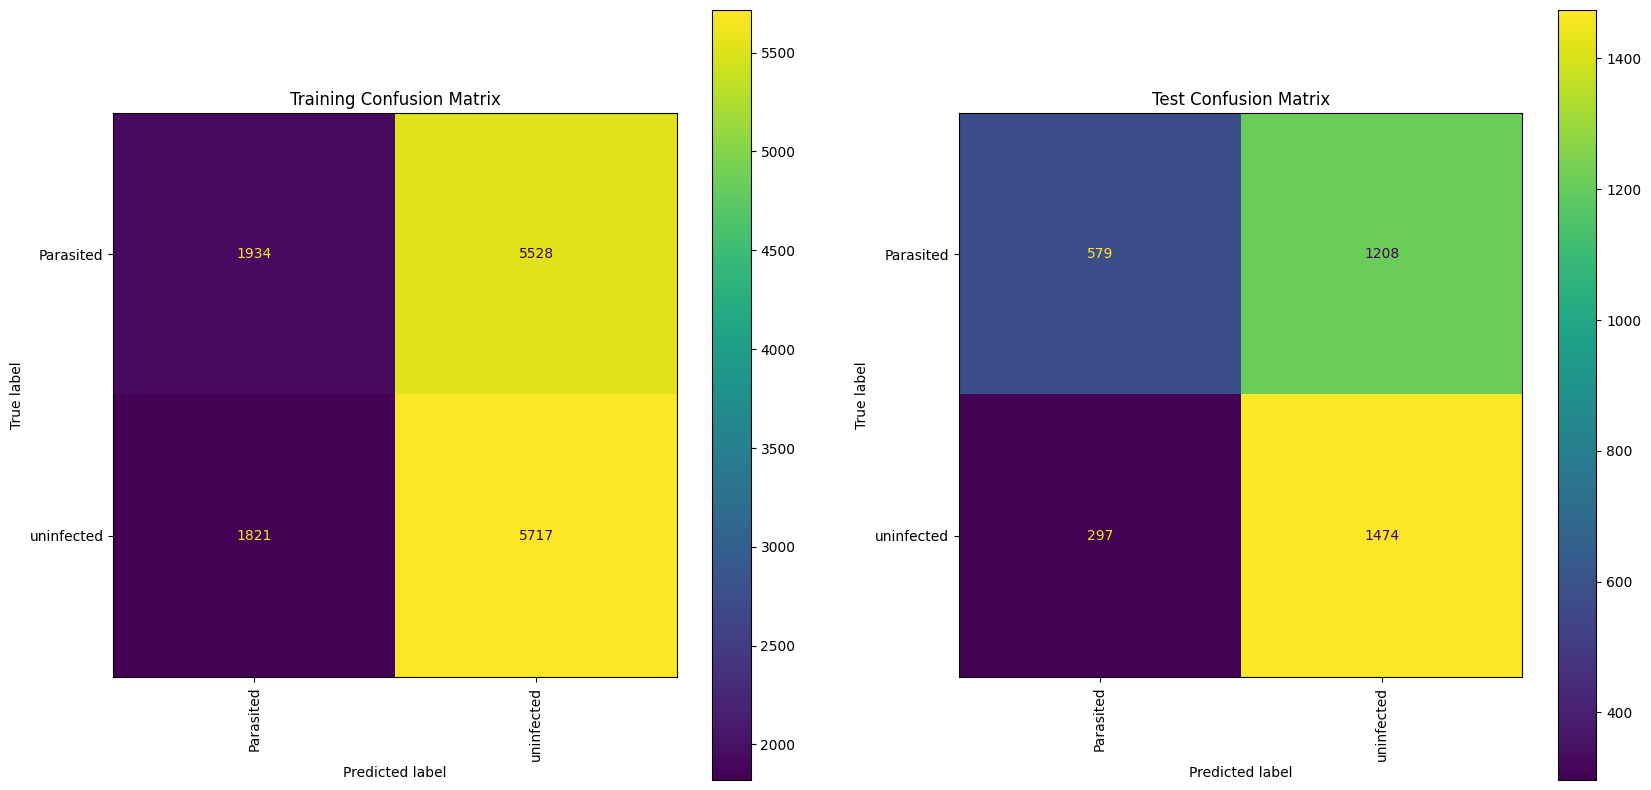

In [21]:
from sklearn import metrics
labels=["Parasited" , "uninfected"]
fig,ax = plt.subplots(1,2, figsize = (20,10))


cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_label_train, result_inference_LB_train, ax = ax[0])
ax[0].set_xticklabels(labels, rotation = 90)
ax[0].set_yticklabels(labels, rotation = 0)
ax[0].set_title('Training Confusion Matrix')


cm_display = metrics.ConfusionMatrixDisplay.from_predictions(true_label_test, result_inference_LB_test, ax = ax[1])
ax[1].set_xticklabels(labels, rotation = 90)
ax[1].set_yticklabels(labels, rotation = 0)
ax[1].set_title('Test Confusion Matrix')

plt.show()

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

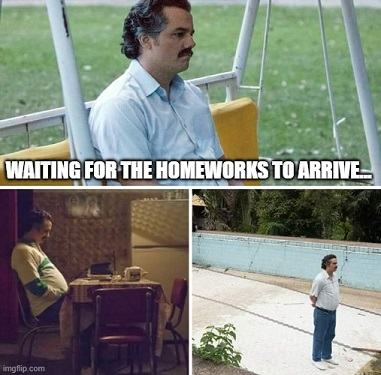